In [1]:
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR,
)

/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://research.zozo.com/data.html からダウンロードしたデータを格納するディレクトリ
data_path = Path.cwd().parents[0] / "data" / "open_bandit_dataset"

## データの読み込みと前処理

p.99

In [3]:
# ZOZOTOWNのトップページ推薦枠でBernoulliTSを利用したデータを用いる
# `data_path=None`とすると試しデータセットを用いることができる
datasets = OpenBanditDataset(
    behavior_policy="bts",
    campaign="men", # men, women or all
    data_path=data_path,    # ロードするデータセットのパス
)

In [4]:
# デフォルトの前処理を施したデータを取得
# タイムスタンプの最初70%を学習データ、残り30%をバリデーションデータとして利用
# _preprocessメソッドをオーバーライドすることで、データの前処理をカスタマイズすることができる
training_data, validation_data = datasets.obtain_batch_bandit_feedback(
    test_size=0.3,
    is_timeseries_split=True
)

In [5]:
training_data.keys()

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

In [6]:
# ファッションアイテムの数
datasets.n_actions

34

In [7]:
# データの数
datasets.n_rounds

4077727

In [8]:
# 特徴量の次元数
datasets.dim_context

27

In [9]:
# 推薦枠のポジション数
datasets.len_list

3

## 意思決定モデルの学習

IPW LearnerとRandom Forest Learnerを使って、意思決定モデルを学習する。

In [10]:
# 内部で用いる分類器としてRandomForestを指定した意思決定モデルを定義する
new_decision_making_model = IPWLearner(
    n_actions=datasets.n_actions,   # ファッションアイテム数
    len_list=datasets.len_list,     # 推薦枠の数
    base_classifier=RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        random_state=12345,
    )
)

new_decision_making_model.fit(
    context=training_data["context"],
    action=training_data["action"],
    reward=training_data["reward"],
    position=training_data["position"],
    pscore=training_data["pscore"],
)

action_dist = new_decision_making_model.predict(
    context=validation_data["context"],
)

## 意思決定モデルの性能評価

In [11]:
# DR推定量を計算するためのモデルを定義する
regression_model = RegressionModel(
    n_actions=datasets.n_actions,
    len_list=datasets.len_list,
    base_model=LogisticRegression(C=100, random_state=12345),
)

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=validation_data["context"],
    action=validation_data["action"],
    reward=validation_data["reward"],
    position=validation_data["position"],
    random_state=12345,
    n_folds=3,
)

/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

In [12]:
# 性能評価を一気通貫で行うためのOffPolicyEvaluationクラスを定義する
ope = OffPolicyEvaluation(
    bandit_feedback=validation_data,
    ope_estimators=[IPS(), DR()],
)

/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


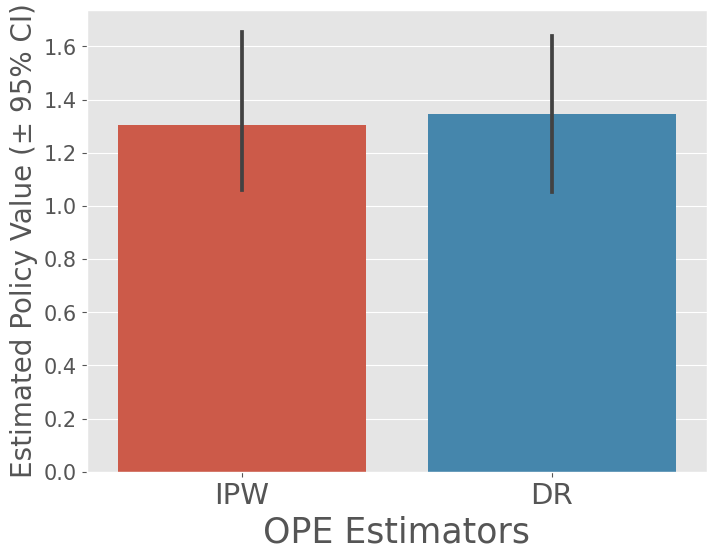

In [13]:
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    is_relative=True,
)